# Explain the Best Model
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import scored data
* Use Shapley Value to explain the model
* Define Ratings with homogeneous group

# 1. Parameters

In [2]:
#Copiar o caminho path_model_mojo do step "5. Exporting the best model to Deploy" no código "2_Fast_Machine_Learning.ipynb"
path_model_mojo = '/home/sagemaker-user/avaliacao/FIEP-Modelos-de-Aprendizado-e-Arquiteturas-Cloud/projeto_final/output_model/models/best/StackedEnsemble_BestOfFamily_4_AutoML_1_20221116_05707.zip'

#Name
ModelName = 'hr_analytics'
#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#Setting the model target variable name
VarTarget = 'is_promoted'
VarId = 'employee_id'
VarDate = 'reference_date'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

# ATENÇÃO: nome do bucket criado no S3 (altere para o bucket com o seu nome)
bucket = 'aula-deploy-modelos1'

CAT = ['department'
,'region'
,'education'
,'recruitment_channel'
,'kpis_met_80']

#float
#Testar as variaveis no_of_trainings e previous_year_rating como categorcias e ver se melhora o modelo
NUM = ['no_of_trainings'
,'previous_year_rating'       
,'age'
,'avg_training_score'
]
selected_features = CAT + NUM

# 2. Import Libraries

In [3]:
try:
    import sys
    sys.path.append('/var/lang/lib/python37.zip')
    sys.path.append('/var/lang/lib/python3.7')
    sys.path.append('/var/lang/lib/python3.7/lib-dynload')
    sys.path.append('/var/lang/lib/python3.7/site-packages')
    sys.path.remove('/opt/.sagemakerinternal/conda/lib/python3.7/site-packages')
except:
    pass

In [4]:
import datetime as dt
import pandas as pd
import numpy as np
import boto3
import awswrangler as wr
import matplotlib.pyplot as plt
import shap
import h2o
import seaborn as sns

# 3. Importing Scored Data for Explain Modeling

In [13]:
#Criar conexão com o Athena
my_boto3_session = boto3.Session(region_name='us-east-1')

In [15]:
query4="select * from auladeploymodelos.%s" % ModelName+'_scored'
datascored_df_full = wr.athena.read_sql_query(query4, database="auladeploymodelos", boto3_session=my_boto3_session)

In [16]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    datascored_df = datascored_df_full.copy()
else:
    datascored_df = datascored_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del datascored_df_full

In [17]:
#Numeric features must be float type
for col_name in NUM:
    datascored_df[col_name] = datascored_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    datascored_df[col_name] = datascored_df[col_name].astype(str)

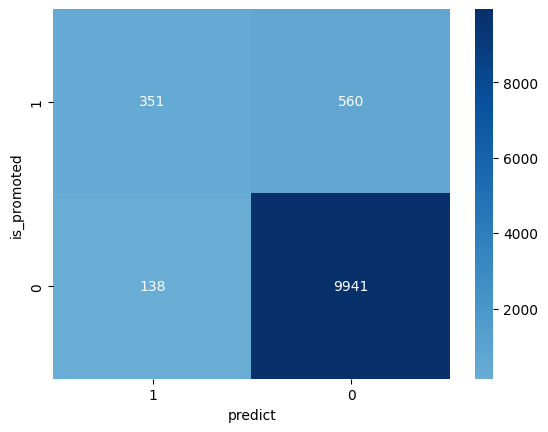

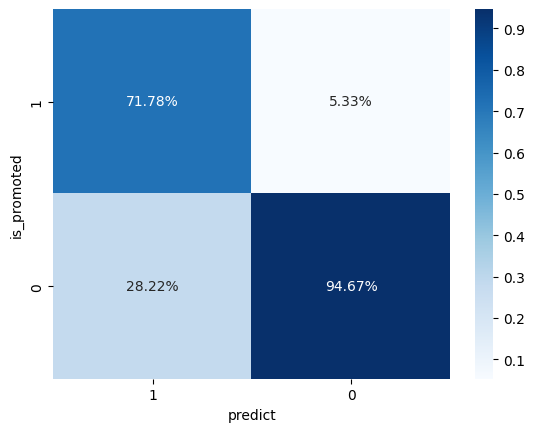

In [18]:
#Confusion Matrix for the Champion
df_matrix = datascored_df.reset_index().groupby([VarTarget, 'predict']).count()[['index']].reset_index().pivot(index=VarTarget, columns='predict', values='index').sort_values(by=[VarTarget], ascending=False).loc[:,(1,0)]

sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

# 4. Calculate Shapley Values using SHAP KernelExplainer for H20 models

#### The SHAP library calculates the Shaley Value of each variable used in the model and shows the individual impact of each variable on the predicted value for each record. To better understand how the SHAP library works, see the link https://github.com/slundberg/shap

In [19]:
#Funcao para calcular o valor de shapley
class H2oProbWrapper:
    def __init__(self, h2o_model, feature_names, NUM, CAT):
        self.h2o_model = h2o_model
        self.feature_names = feature_names
        self.NUM = NUM
        self.CAT = CAT
    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1) 
        self.dataframe = pd.DataFrame(X, columns=self.feature_names)

        #Numeric features must be float type
        for col_name in self.NUM:
            self.dataframe[col_name] = self.dataframe[col_name].astype(float)

        #Categorical features must be string type and null values will be filled with "Missing"
        for col_name in self.CAT:        
            self.dataframe = self.dataframe.astype(str)
            self.dataframe = self.dataframe.fillna(value={col_name: 'Missing'})

        self.predictions = h2o.mojo_predict_pandas(self.dataframe.set_index(self.feature_names[0], inplace=False), mojo_zip_path=self.h2o_model, verbose=False).loc[:,('predict','p1')]        
        return self.predictions['p1'].astype('float64').values

In [20]:
#The calculation of the Shapley Value for H20 models takes a while. So it will only be done for 20 records. Increase the sample to deepen your analysis
shap_sample = datascored_df.loc[:,(selected_features)].sample(n=50, replace=False, random_state=1)
shap_sample = shap_sample.fillna(0)

In [21]:
h2o_wrapper = H2oProbWrapper(path_model_mojo, selected_features, NUM, CAT)
h2o_explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob, shap_sample)
h2o_shap_values = h2o_explainer.shap_values(shap_sample, nsamples="auto")

  0%|          | 0/50 [00:00<?, ?it/s]

## 4.1 Main SHAP Graphics

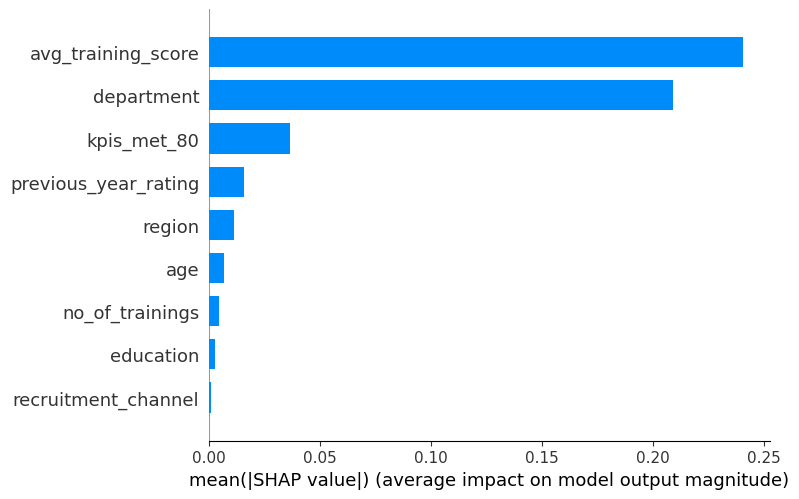

None

In [22]:
fig = shap.summary_plot(h2o_shap_values, shap_sample, plot_type="bar", show=True)
display(fig)

None

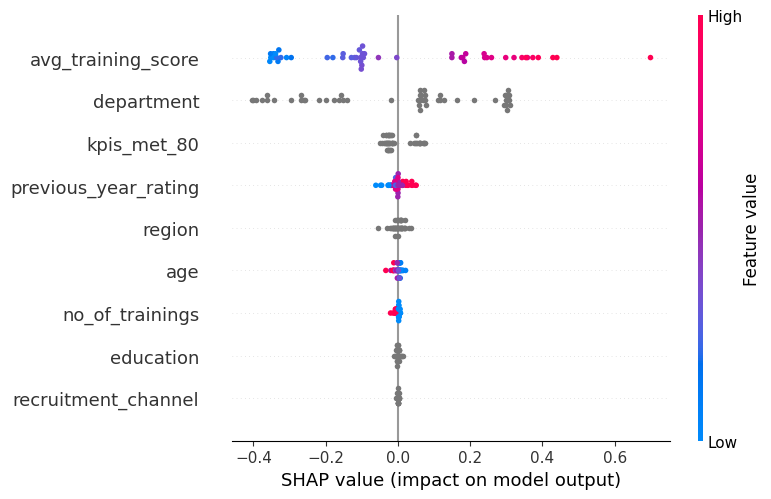

In [23]:
display(shap.summary_plot(h2o_shap_values, shap_sample, show=False))

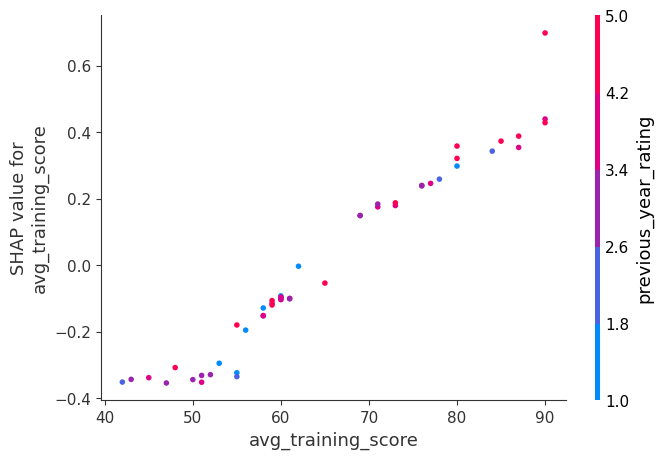

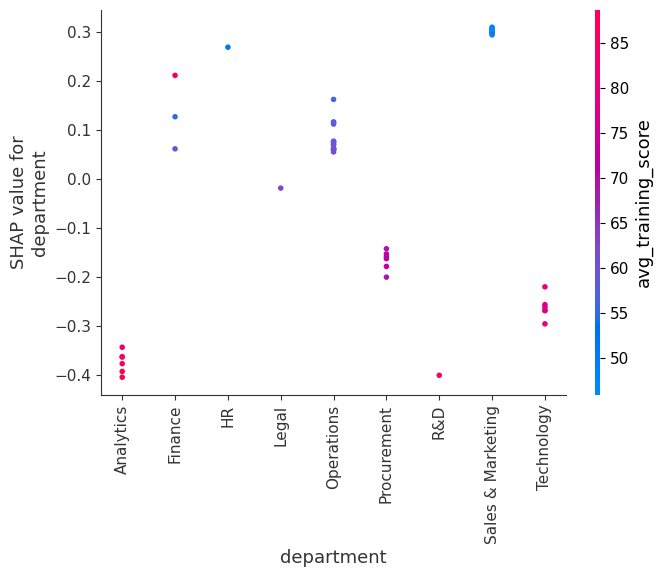

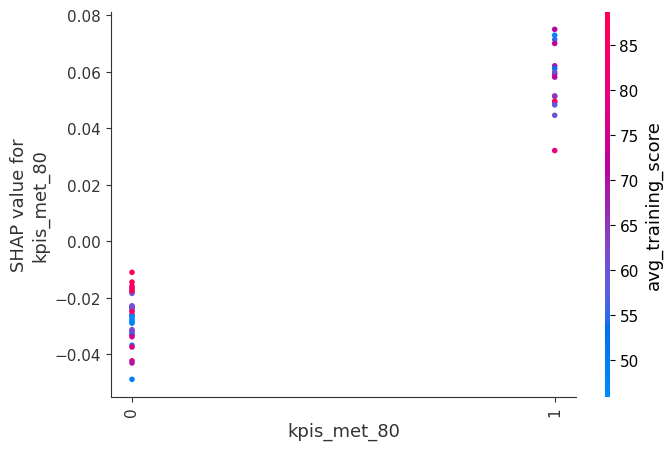

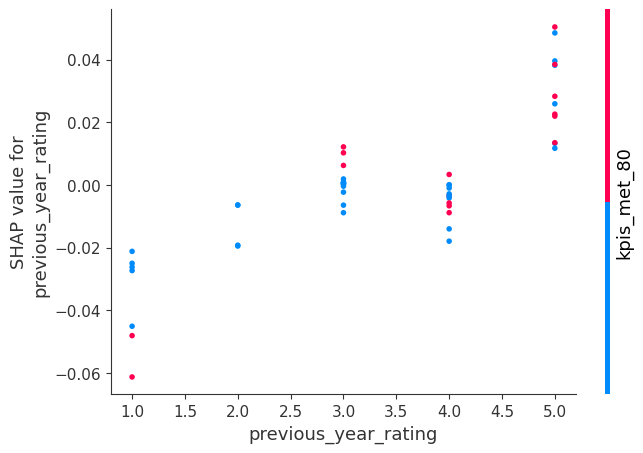

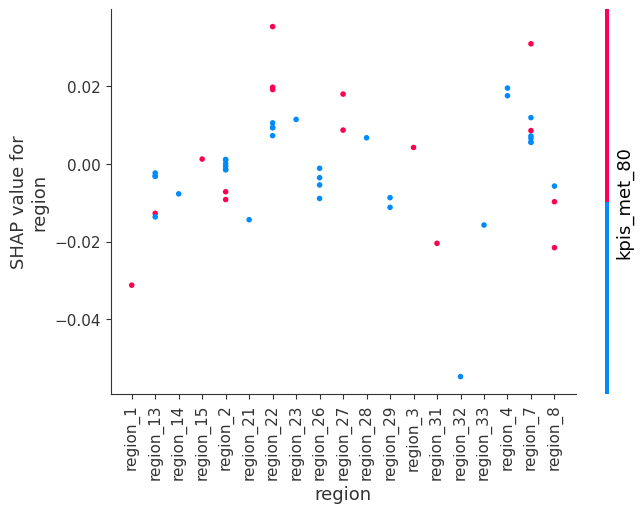

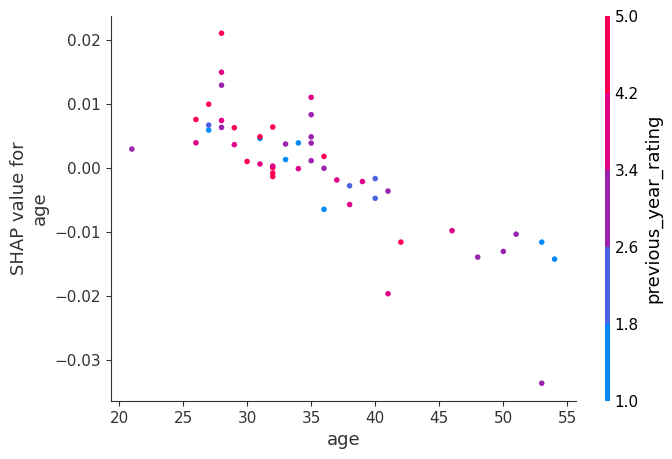

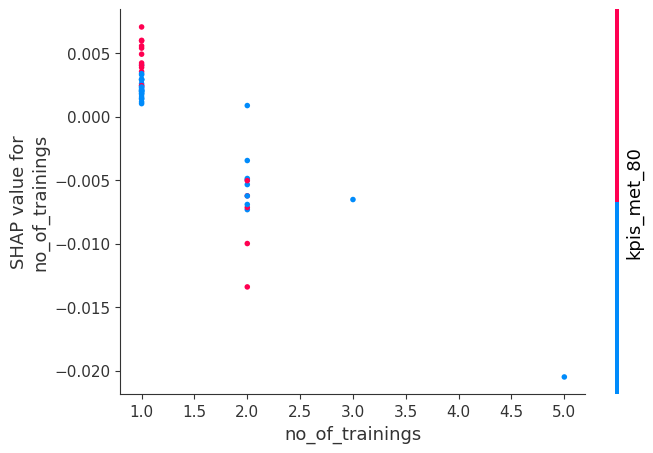

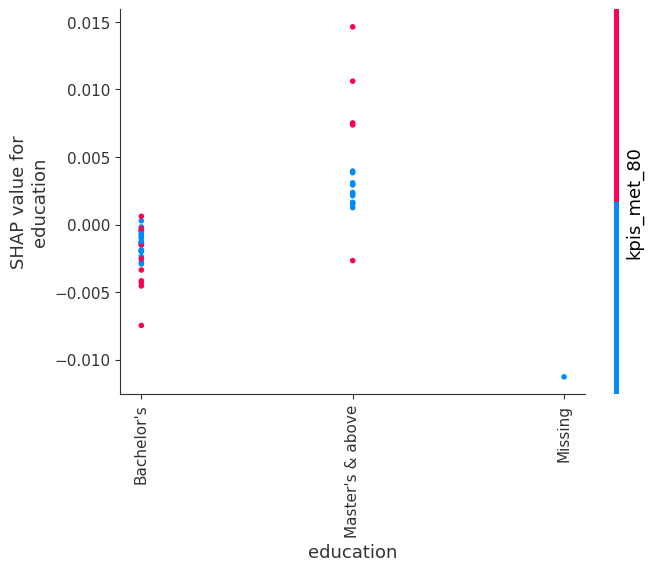

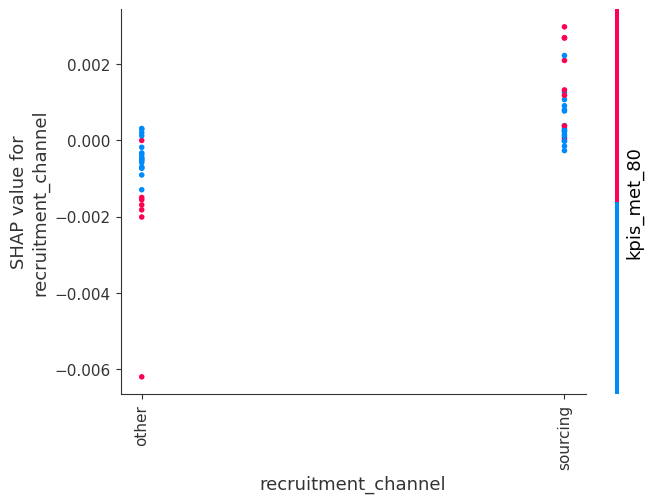

In [24]:
#sort the features indexes by their importance in the model
#(sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(h2o_shap_values),0))

#make SHAP plots of the three most important features
for i in range(len(selected_features)):
    fig=shap.dependence_plot(top_inds[i], h2o_shap_values, shap_sample, show=False)
#     display(fig)

## 4.2 Shap Force Plot

In [25]:
df_shap_values = pd.DataFrame(h2o_shap_values)
df_shap_values['sum_shap'] = df_shap_values.sum(axis=1)

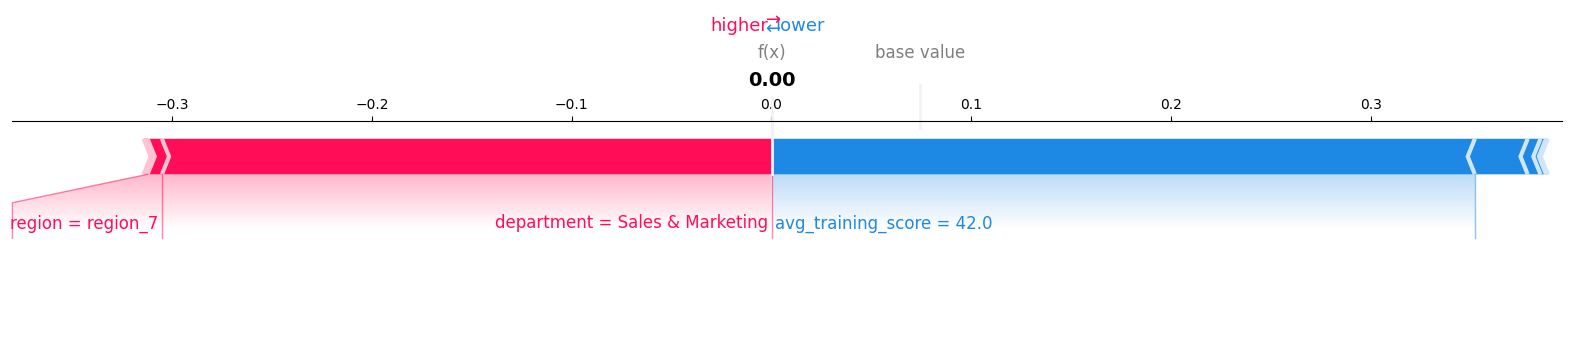

None

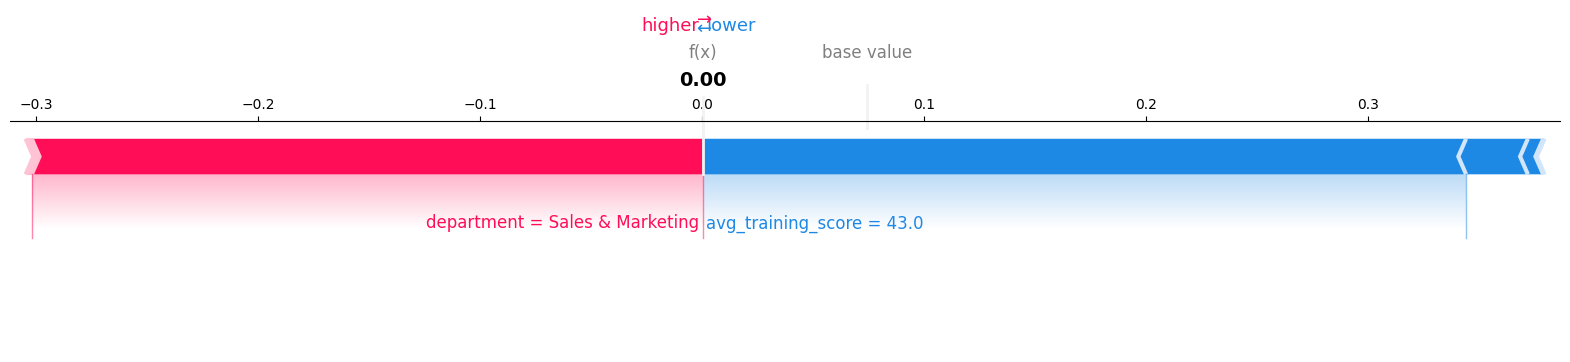

None

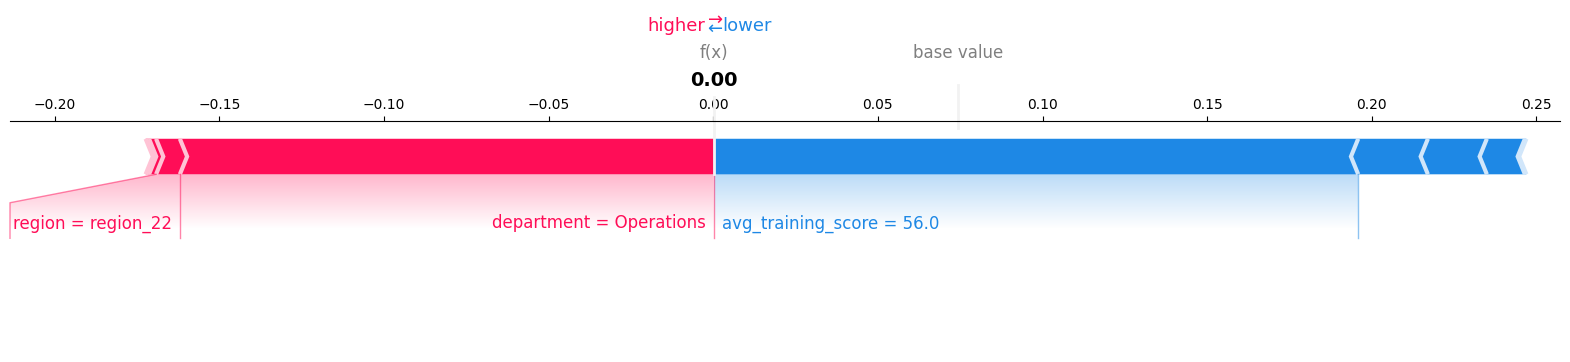

None

In [26]:
for i in df_shap_values.sort_values(by='sum_shap').iloc[0:3,:].index.values:
    fig = shap.force_plot(h2o_explainer.expected_value, h2o_shap_values[i,:], shap_sample.iloc[i,:], matplotlib=True, show=True)
    display(fig)

## 4.3 Shap Waterfall Plot

In [ ]:
#for i in df_shap_values.sort_values(by='sum_shap').iloc[0:6,:].index.values:
#    fig = shap.plots._waterfall.waterfall_legacy(h2o_explainer.expected_value, h2o_shap_values[i,:], shap_sample.iloc[i,:].to_numpy(), selected_features, show=True)
#   display(fig)

# 5. Define Ratings with homogeneous group

In [34]:
'''
def calculate_IV(dataframe, coluna_feature, coluna_target, cat_goods = None, buckets=20):
    
    #Function to calculate the IV.
    #    Parameters
    #     dataframe: DataFrame with the input and target variables.
    #     column_feature (str): Name of the variable that contains the independent variable.
    #      column_target (str): Name of the variable that contains the dependent variable or target.
    #      cat_goods (str): Level of the target variable that should be considered "GOOD", if it is categorical.
    #      buckets (int): Number of partitions to be created in numeric variables.
    
    Returns
    stats (list):
    List with:
        [1] IV
        [0] dataframe pandas with statistics table
  
    
    # Initial definitions
    df = dataframe.loc[:,(coluna_feature, coluna_target)]
    tpVar = 'categorical'    
    
    #If the variable is numeric (float or int), it creates a category for discretization
    if df[coluna_feature].dtype=='float64' or df[coluna_feature].dtype=='int64' or df[coluna_feature].dtype=='int32' or df[coluna_feature].dtype=='float32':
        tpVar='numeric'
        coluna_feature_bucket = coluna_feature + "_bucket"
        #create buckets using qcut
        df[coluna_feature_bucket] = pd.qcut(df[coluna_feature], buckets, labels=False, duplicates='drop')
        analyse_df = df.groupby(coluna_feature_bucket).agg({coluna_target: ['count', 'sum'], coluna_feature: ['min', 'max']})
        analyse_df.columns = ['_'.join(tup).rstrip('_') for tup in analyse_df.columns.values]
        analyse_df.rename(columns={(coluna_target+'_count'):'qty', (coluna_target+'_sum'):'qty_goods'}, inplace=True)
        
    #Categorical variables
    if tpVar == 'categorical':
        analyse_df = df.groupby(coluna_feature).agg({coluna_target: ['count', 'sum']})
        analyse_df.columns = ['_'.join(tup).rstrip('_') for tup in analyse_df.columns.values]
        analyse_df.rename(columns={(coluna_target+'_count'):'qty', (coluna_target+'_sum'):'qty_goods'}, inplace=True)
        
    #IV Calculation
    analyse_df.loc[:, 'qty_bads'] = analyse_df.loc[:,'qty'] - analyse_df.loc[:,'qty_goods']
    analyse_df.loc[:, 'tot_goods'] = analyse_df.loc[:,'qty_goods'].sum()
    analyse_df.loc[:, 'tot_bads'] = analyse_df.loc[:,'qty_bads'].sum()
    analyse_df.loc[:, 'perc_goods'] = analyse_df.loc[:,'qty_goods'] / analyse_df.loc[:,'tot_goods']
    analyse_df.loc[:, 'perc_bads'] = analyse_df.loc[:,'qty_bads'] / analyse_df.loc[:,'tot_bads']
    analyse_df.loc[:, 'good_rate'] = analyse_df.loc[:,'qty_goods'] / analyse_df.loc[:,'qty']
    analyse_df.loc[:, 'odds'] = analyse_df.loc[:,'perc_goods'] / analyse_df.loc[:,'perc_bads']
    analyse_df.loc[:, 'ln_odds'] = np.log2(analyse_df['odds'])
    analyse_df.loc[:, 'iv_cat'] = (analyse_df.loc[:,'perc_goods'] / analyse_df.loc[:,'perc_bads']) * analyse_df.loc[:, 'ln_odds']
    
    if tpVar == 'numeric':
        analyse_df.reset_index(inplace=True)
        tabela_pdf = analyse_df.loc[:, (coluna_feature_bucket, coluna_feature+"_min", coluna_feature+"_max", 'qty', 'good_rate', 'odds', 'iv_cat')]
    else:
        analyse_df.reset_index(inplace=True)
        tabela_pdf = analyse_df.loc[:, (coluna_feature, 'qty', 'good_rate', 'odds', 'iv_cat')]
        
    df_iv = tabela_pdf.query('iv_cat != inf')['iv_cat'].sum()
    resultado = [df_iv, tabela_pdf]
    return resultado

def colunas_dataframe(dataframe):
    lista_colunas = []
    lista_colunas = [i for i in dataframe.columns if i in selected_features]
    return lista_colunas

def table_iv(dataframe):
    lista_colunas = colunas_dataframe(dataframe)
    dict_resultados = {}
    for col in lista_colunas:
        print("{0:.0%}".format((lista_colunas.index(col)+1) / (len(lista_colunas)+1)) + ":" + col)              
        dict_resultados[col] = calculate_IV(dataframe=dataframe, coluna_feature=col, coluna_target=VarTarget, buckets=10)
    return dict_resultados
    '''

In [ ]:
#Calcular Taxa de Bons, IV, ODDS e WOE
#IV_p1=calculate_IV(dataframe=datascored_df, coluna_feature='p1', coluna_target=VarTarget, buckets=20)
#IV_p1

## 5.1 Escolher as faixas que podem ser agrupadas

In [ ]:
#for i in range(len(IV_p1[1].p1_max)):
    #se for o primeiro iniciar com if ao inves de elif
#    if i==0:
#        print('if p1 <= '+str(IV_p1[1].p1_max.iloc[i])+':')
#        print('    return '+ str(i+1))
    #se for o ultimo finalizar com else ao inves de elif
#    elif i==(len(IV_p1[1].p1_max))-1:
#        print('else:')
#        print('    return '+ str(i+1))
#    else:
#        print('elif p1 <= '+str(IV_p1[1].p1_max.iloc[i])+':')
 #       print('    return '+ str(i+1))

In [ ]:
#def ratings(p1): 
#    if p1 <= 0.2508362656036639:
#        return 1
#    elif p1 <= 0.6540492277407066:
#        return 2
#    else:
#        return 3

In [ ]:
#Criar GHs
#datascored_df['GH'] = datascored_df.apply(lambda x: ratings(x['p1']),axis=1).astype(str)

## 5.2 Calcular o IV do GH após a definição das faixas

In [26]:
#Aqui precisa ser somente OOT
#IV_GH=calculate_IV(dataframe=datascored_df, coluna_feature='GH', coluna_target=VarTarget)
#IV_GH[1];

In [ ]:
#IV_GH_graf = IV_GH[1]
#IV_GH_graf['GH'] = IV_GH_graf['GH'].astype(int)
#IV_GH_graf = IV_GH_graf.sort_values(by='GH')
#IV_GH_graf.set_index('GH', inplace=True)
#IV_GH_graf

#IV_GH_graf['Distribuicao'] = IV_GH_graf.qty / IV_GH_graf.qty.sum()
#df_plot_gh_t1 = IV_GH_graf.reset_index().loc[:, ('GH', 'Distribuicao')]
#df_plot_gh_t1['GH'] = df_plot_gh_t1.GH.astype(str)
#df_plot_gh_t1 = df_plot_gh_t1.set_index('GH')

#df_plot_gh_t2 = IV_GH_graf.reset_index().loc[:, ('GH', 'good_rate')]
#df_plot_gh_t2['GH'] = df_plot_gh_t2.GH.astype(str)
#df_plot_gh_t2 = df_plot_gh_t2.set_index('GH')

#target_mean = sum(IV_GH[1].qty * IV_GH[1].good_rate) / sum(IV_GH[1].qty)

#calculate o KS in test dataset
#kstable = IV_GH_graf.sort_values(by="good_rate", ascending=False).copy()
#kstable['events'] = (kstable['qty']*kstable['good_rate'])
#kstable['nonevents'] = (kstable['qty']*(1-kstable['good_rate']))
#kstable['event_rate'] = (kstable.events / kstable['events'].sum()).apply('{0:.2%}'.format)
#kstable['nonevent_rate'] = (kstable.nonevents / kstable['nonevents'].sum()).apply('{0:.2%}'.format)
#kstable['cum_eventrate'] = (kstable.events / kstable['events'].sum()).cumsum()
#kstable['cum_noneventrate'] = (kstable.nonevents / kstable['nonevents'].sum()).cumsum()
#kstable['cum_eventrate'] = kstable['cum_eventrate'].astype(float)
#kstable['cum_noneventrate'] = kstable['cum_noneventrate'].astype(float)
#kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
#ks = kstable['KS'].max()

#ax = df_plot_gh_t2.good_rate.plot(secondary_y=False, ylim=[0,1], kind="line", rot=0, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
#for p in range(len(df_plot_gh_t2)):
    #ax.annotate(str(int(df_plot_gh_t2.reset_index().iloc[p,1]*100)/100), (int(df_plot_gh_t2.reset_index().iloc[p, 0])-1, df_plot_gh_t2.reset_index().iloc[p, 1] * 1.1))
#    ax.annotate(str('{0:.1%}'.format(int(df_plot_gh_t2.reset_index().iloc[p,1]*1000)/1000))\
#                ,(df_plot_gh_t2.reset_index().index.values[p]+0.0\
#                 ,df_plot_gh_t2.reset_index().iloc[p,1]+0.04))
#    ax.annotate(str('{0:.1%}'.format(int(df_plot_gh_t1.reset_index().iloc[p,1]*1000)/1000))\
#                ,(df_plot_gh_t1.reset_index().index.values[p]-0.2\
#                  ,0))
#ax.annotate(str('{0:.1%}'.format(int(target_mean*1000)/1000))\
#            ,(7.5\
#              ,target_mean))
#ax.annotate(str('KS: {0:.1%}'.format(ks)),(len(df_plot_gh_t1)/2-1,0.5))
#df_plot_gh_t1.Distribuicao.plot(ylim=[0,1], kind='bar', rot=0, figsize=(4,3), linewidth=2, fontsize=12, grid=True, legend=1, title="GHs Distribution (Out of Sample)")
#ax.axhline(y=target_mean, color='r', linestyle='--')
# display(ax)

# 6. Predict Submision dataset using MOJO or H2O Model

In [35]:
test = pd.read_csv('./HR_Analytics/test_2umaH9m.csv')

In [36]:
test.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
dtype: object

In [37]:
# rename columns for low case
for i in test.columns:    
    test=test.rename(columns={i: i.lower()})

In [38]:
# #criar o prefix para a variavel cabine (A, B, C, D, ou E)
# test['cabine_prefix'] = test['cabin'].str[0:1]
# test = test.fillna(value={'cabine_prefix': 'missing'})

# #Tratamento da idade
# test['age_mean'] = test['age'].fillna(test['age'].mean())

# #Tiket
# import re
# for i in range(len(test)):
#     t=test.loc[i:i,'ticket'].values
#     t2=re.sub("[^0-9]", "", str(t))
#     t3=re.sub('[^A-Za-z]+', '', str(t))
#     if t2 != "":
#         test.loc[i:i,'ticket_int']=int(t2)
#     if t3 != "":
#         if t3 == 'SC':
#             t3 = 'SCAHBasle'
#         if t3 == 'SOP':
#             t3 = 'SOPP'
#         if t3 == 'C':
#             t3 = 'CA'
#         if t3 == 'FC':
#             t3 = 'FCC'
#         if t3 == 'PP':
#             t3 = 'PPP'
#         if t3 == 'SCOW':
#             t3 = 'Fa'
#         if t3 in ('AS', 'CASOTON', 'Fa', 'SCA','SOPP','SOTONO','SP'):
#             t3='LOW'
#         test.loc[i:i,'ticket_str']=str(t3)

# test['ticket_int'] = test['ticket_int'].fillna(0)
# test = test.fillna(value={'ticket_str': 'missing'})


# #Name: Criar uma categoria com o titulo do nome
# for i in range(len(test)):
#     t1 = str(test.loc[i:i,'name'].values)
#     t2 = t1[0:t1.find('.')].split()[-1]
#     if t2 in ('Rev', 'Capt', 'Don', 'Jonkheer'):
#         t2='LOW'
#     if t2 in ('Lady', 'Mme'):
#         t2='Miss'
#     test.loc[i:i,'nametitle']=str(t2)

# #Numeric features must be float type
# for col_name in NUM:    
#     test[col_name] = test[col_name].astype(float)    

# #Categorical features must be string type and null values will be filled with "missing"
# for col_name in CAT:        
#     test[col_name] = test[col_name].astype(str)    
#     test = test.fillna(value={col_name: 'missing'}) 

In [41]:
#Importar MOJO
test_tmp = h2o.mojo_predict_pandas(test, path_model_mojo)    
predict_df = test.merge(test_tmp, left_index=True, right_index=True)
    
predict_df.rename(columns={'predict':'is_promoted'}, inplace=True)
predict_df = predict_df.reset_index(drop=True)
predict_df = predict_df.loc[:, ('employee_id', 'is_promoted')]
predict_df

There were 1 missing columns found in the input data set: {kpis_met_80}
Detected 6 unused columns in the input data set: {,gender,awards_won?,kpis_met >80%,length_of_service,employee_id}


,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0
...,...,...
23485,53478,0
23486,25600,0
23487,45409,0
23488,1186,0


## 8.1 Save final dataset with predictions for submissions in https://www.kaggle.com/competitions/titanic/submissions

In [42]:
predict_df.loc[:, ('employee_id', 'is_promoted')].to_csv('./HR_Analytics/HR_Analytics_submission.csv', index=False)